In [ ]:
#!pip install --quiet numpy pandas gymnasium matplotlib pogema seaborn tqdm

In [102]:
import os
from tqdm import tqdm
from algorithms import JALGT
from solution_concepts import MinimaxSolutionConcept, ParetoSolutionConcept, NashSolutionConcept, WelfareSolutionConcept
from game_model import GameModel
import numpy as np
import random
from gymnasium import Wrapper
from pogema import pogema_v0, GridConfig
from pogema.animation import AnimationMonitor, AnimationConfig
from utils import draw_history
from IPython.display import display, SVG

## Representación de la observación parcial como estado

Intentamos que sea lo más compacta posible para que el espacio de estados sea manejable.

In [103]:
def obs_to_state(obs):
    matrix_obstacles = obs[0]
    matrix_agents = obs[1]
    matrix_target = obs[2]

    # Representación del objetivo:
    #  Ocupa 2 bits
    #  0 si el objetivo está arriba, diagonal arriba-izquierda o diagonal arriba-derecha
    #  1 si el objetivo está abajo, diagonal abajo-izquierda o diagonal abajo-derecha
    #  2 si el objetivo está a la izquierda (no en diagonal)
    #  3 si el objetivo está a la derecha (no en diagonal)
    target = np.max(matrix_target[2]) * 1 + \
             matrix_target[1][0] * 2 + matrix_target[1][2] * 3

    # Representación de los obstáculos:
    #  Shift de 2^6, ocupando 4 bits
    #  2^9 si hay un obstáculo arriba (no diagonal)
    #  2^8 si hay un obstáculo a la izquierda (no diagonal)
    #  2^7 si hay un obstáculo a la derecha (no diagonal)
    #  2^6 si hay un obstáculo abajo (no diagonal)
    obstacles = matrix_obstacles[0][1] * 2 ** 9 + \
                matrix_obstacles[1][0] * 2 ** 8 + \
                matrix_obstacles[1][2] * 2 ** 7 + \
                matrix_obstacles[2][1] * 2 ** 6

    # Representación de los otros agentes:
    #  Shift de 2^2, ocupando 4 bits
    #  2^5 si hay un agente arriba (no diagonal)
    #  2^4 si hay un agente a la izquierda (no diagonal)
    #  2^3 si hay un agente a la derecha (no diagonal)
    #  2^2 si hay un agente abajo (no diagonal)
    agents = matrix_agents[0][1] * 2 ** 5 + \
             matrix_agents[1][0] * 2 ** 4 + \
             matrix_agents[1][2] * 2 ** 3 + \
             matrix_agents[2][1] * 2 ** 2

    return int(obstacles + agents + target)

## Función de recompensa

Como hacíamos con FrozenLake, añadimos una penalización por cada paso de tiempo gastado.

Tenemos acceso a la observación anterior, por si queremos hacer algo con ella. Por ejemplo, detectar colisiones.

In [104]:
class RewardWrapper(Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, joint_action):
        # En caso de que queráis utilizar las observaciones anteriores, utilizad este objeto:
        previous_observations = self.env.unwrapped._obs()

        observations, rewards, terminated, truncated, infos = self.env.step(joint_action)
        for i in range(len(joint_action)):
            if not terminated[i] and not truncated[i]:
                if rewards[i] == 0:  # Penalización por tardar más en llegar
                    rewards[i] = rewards[i] - 0.01
        return observations, rewards, terminated, truncated, infos


def create_env(config, seed=42):
    grid_config = GridConfig(num_agents=config["num_agents"],
                             size=config["size"],
                             density=config["obstacle_density"],
                             seed=seed,
                             max_episode_steps=config["episode_length"],
                             obs_radius=1,
                             on_target="finish",
                             render_mode=None)
    animation_config = AnimationConfig(directory='renders/',  # Dónde se guardarán las imágenes
                                       static=False,
                                       show_agents=True,
                                       egocentric_idx=None,  # Punto de vista
                                       save_every_idx_episode=config["save_every"],  # Guardar cada save_every episodios
                                       show_border=True,
                                       show_lines=True)
    env = pogema_v0(grid_config)
    env = AnimationMonitor(env, animation_config=animation_config)
    return RewardWrapper(env)  # Añadimos nuestra función de recompensa

## Configuración del experimento

In [117]:
exp_config = {
        "num_agents": 2,  # Número de agentes
        "size": 4,  # Tamaño del mapa (valor de anchura y valor de altura)
        "maps": 10,  # Número de mapas a entrenar y evaluar (se repiten si episodios > mapas)
        "num_states": 16 * 16 * 4,  # Obstacle representation x Agent representation x Target representation
        "epochs": 200,  # Cada epoch es un entrenamiento de un número de episodios y una evaluación
        "episodes_per_epoch": 10,  # Número mínimo de episodios por epoch de entrenamiento
        "episode_length": 16,  # Número máximo de pasos por episodio, se trunca si se excede
        "obstacle_density": 0.1,  # Probabilidad de tener un obstáculo en el mapa
        "save_every": None,  # Frecuencia con que se guarda el SVG con la animación de la ejecución
        "learning_rate": 0.01, #0.01,  # alpha
        "epsilon_max": 1,  # epsilon inicial por epoch
        "epsilon_min": 0.1,  # cota mínima de epsilon
        "renders": "renders/",  # directorio donde generar las animaciones
        "solution_concept": WelfareSolutionConcept
    }

Creamos el directorio para los renders:

In [112]:
try:
    os.mkdir(exp_config["renders"])
except:
    pass

## Entrenamiento y evaluación

Declaración del modelo de juego y de los algoritmos para cada agente:

In [113]:
game = GameModel(num_agents=exp_config["num_agents"], num_states=exp_config["num_states"],
                 num_actions=5)  # STAY, UP, DOWN, LEFT, RIGHT

#'''
algorithms = [JALGT(i, game, exp_config["solution_concept"](), epsilon=exp_config["epsilon_max"],
                    alpha=exp_config["learning_rate"], seed=i)
              for i in range(game.num_agents)]
#'''

#Distintos conceptos de solucion
'''
algorithms = [JALGT(0, game, WelfareSolutionConcept(), epsilon=exp_config["epsilon_max"],
                    alpha=exp_config["learning_rate"], seed=0)]

algorithms.append(JALGT(1, game, MinimaxSolutionConcept(), epsilon=exp_config["epsilon_max"],
                    alpha=exp_config["learning_rate"], seed=1))
'''

'\nalgorithms = [JALGT(0, game, WelfareSolutionConcept(), epsilon=exp_config["epsilon_max"],\n                    alpha=exp_config["learning_rate"], seed=0)]\n\nalgorithms.append(JALGT(1, game, MinimaxSolutionConcept(), epsilon=exp_config["epsilon_max"],\n                    alpha=exp_config["learning_rate"], seed=1))\n'

Variable auxiliar para indicar el decremento de epsilon después de cada episodio. Este decremento es lineal. Se puede hacer un decremento exponencial, modificando el código de manera acorde.

In [114]:
epsilon_diff = (exp_config["epsilon_max"] - exp_config["epsilon_min"]) / exp_config["episodes_per_epoch"]

Variables auxiliares para almacenar métricas:

In [115]:
reward_per_epoch = []
td_error_per_epoch = []
reward_per_agent_epoch = [[] for _ in range(exp_config['num_agents'])]

Código de entrenamiento y evaluación, bucle sobre epochs:

In [116]:
pbar = tqdm(range(exp_config["epochs"]))  # Barra de progreso
for epoch in pbar:
    all_eval_rewards = []
    all_td_errors = []

    # Entrenamiento
    ###############
    for ep in range(exp_config["episodes_per_epoch"]):
        pbar.set_postfix({'modo': 'entrenamiento', 'episodio': ep})
        env = create_env(config=exp_config, seed=ep % exp_config["maps"])
        observations, infos = env.reset()
        terminated = truncated = [False, ...]
        train_rewards = [0] * game.num_agents
        states = [obs_to_state(observations[i]) for i in range(game.num_agents)]
        while not all(terminated) and not all(truncated):  # Hasta que acabe el episodio
            # Elegimos acciones
            actions = tuple([algorithms[i].select_action(states[i]) for i in range(game.num_agents)])
            # Ejecutamos acciones en el entorno
            observations, rewards, terminated, truncated, infos = env.step(actions)
            # Aprendemos: actualizamos valores Q
            [algorithms[i].learn(actions, rewards, states[i], obs_to_state(observations[i]))
             for i in range(game.num_agents)]
            # Actualizamos métricas
            train_rewards = [train_rewards[i] + rewards[i] for i in range(game.num_agents)]
            all_td_errors.append(algorithms[0].metrics["td_error"][-1])
            # Preparar siguiente iteración: convertir observaciones parciales en estados
            states = [obs_to_state(observations[i]) for i in range(game.num_agents)]
        # Actualizamos epsilon
        [algorithms[i].set_epsilon(exp_config["epsilon_max"] - epsilon_diff * ep) for i in range(game.num_agents)]
    td_error_per_epoch.append(sum(all_td_errors))

    # Evaluación
    ############
    evaluation_episodes = exp_config["maps"]
    all_eval_rewards = []
    all_eval_rewards_per_agent = [0] * exp_config["num_agents"]
    for ep in range(evaluation_episodes):
        pbar.set_postfix({'modo': 'evaluación...', 'episodio': ep})
        env = create_env(config=exp_config, seed=ep)  # Reaprovechamos mapas del entrenamiento
        observations, infos = env.reset()
        terminated = truncated = [False, ...]
        total_rewards = [0] * exp_config["num_agents"]
        states = [obs_to_state(observations[i]) for i in range(game.num_agents)]
        while not all(terminated) and not all(truncated):  # Hasta que acabe el episodio
            states = [obs_to_state(observations[i]) for i in range(game.num_agents)]
            actions = tuple([algorithms[i].select_action(states[i], train=False)
                             for i in range(game.num_agents)])
            observations, rewards, terminated, truncated, infos = env.step(actions)
            total_rewards = [total_rewards[i] + rewards[i] for i in range(exp_config["num_agents"])]
        # Guardamos animaciones
        for agent_i in range(exp_config["num_agents"]):
            solution_concept_name = exp_config["solution_concept"].__name__
            env.save_animation(f"{exp_config['renders']}/{solution_concept_name}-map{ep}-agent{agent_i}-epoch{epoch}.svg",
                               AnimationConfig(egocentric_idx=agent_i, show_border=True, show_lines=True))
        all_eval_rewards.append(sum(total_rewards))
        for i in range(exp_config["num_agents"]):
            all_eval_rewards_per_agent[i] += total_rewards[i]
    pbar.set_description(f"Recompensa colectiva del último epoch = {'{:>6.6}'.format(str(sum(all_eval_rewards)))}")
    reward_per_epoch.append(sum(all_eval_rewards))
    for i in range(exp_config["num_agents"]):
        reward_per_agent_epoch[i].append(all_eval_rewards_per_agent[i])

  0%|          | 0/200 [00:00<?, ?it/s, modo=entrenamiento, episodio=0]

Recompensa colectiva del último epoch =  -1.42:   0%|          | 1/200 [00:22<1:15:37, 22.80s/it, modo=entrenamiento, episodio=7]


KeyboardInterrupt: 

Gráficas con el resultado de la recolección de métricas:

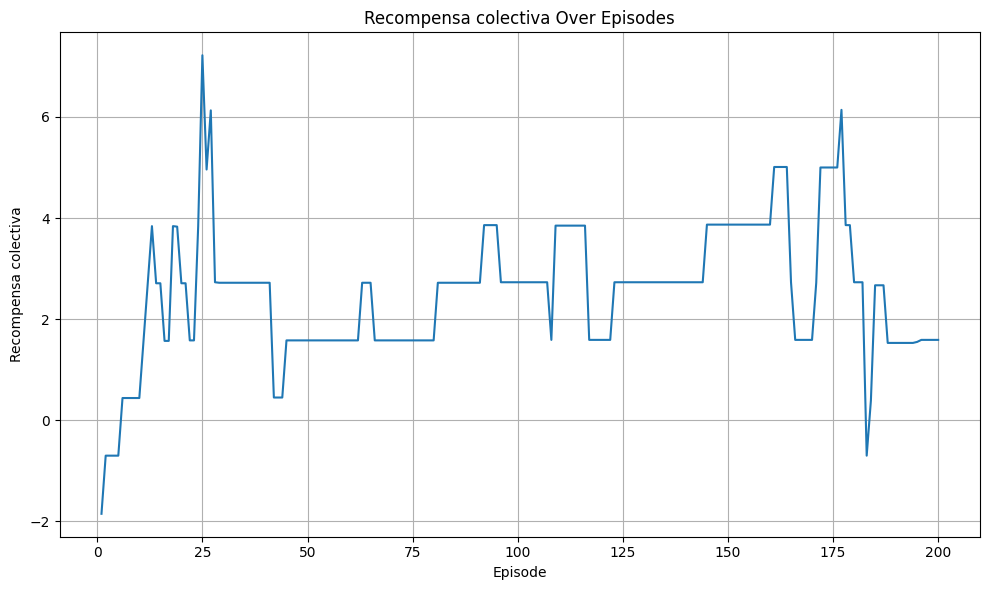

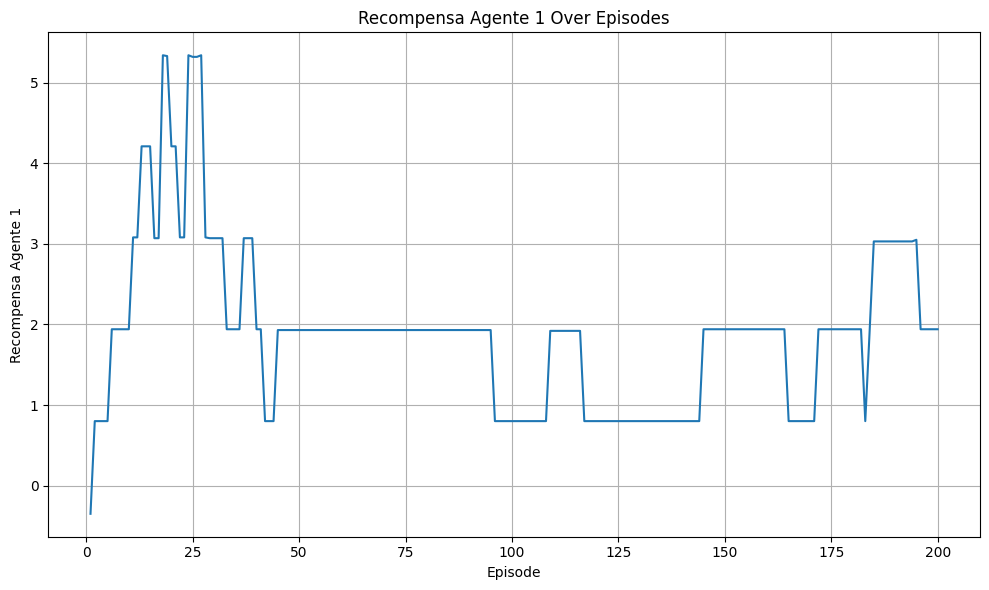

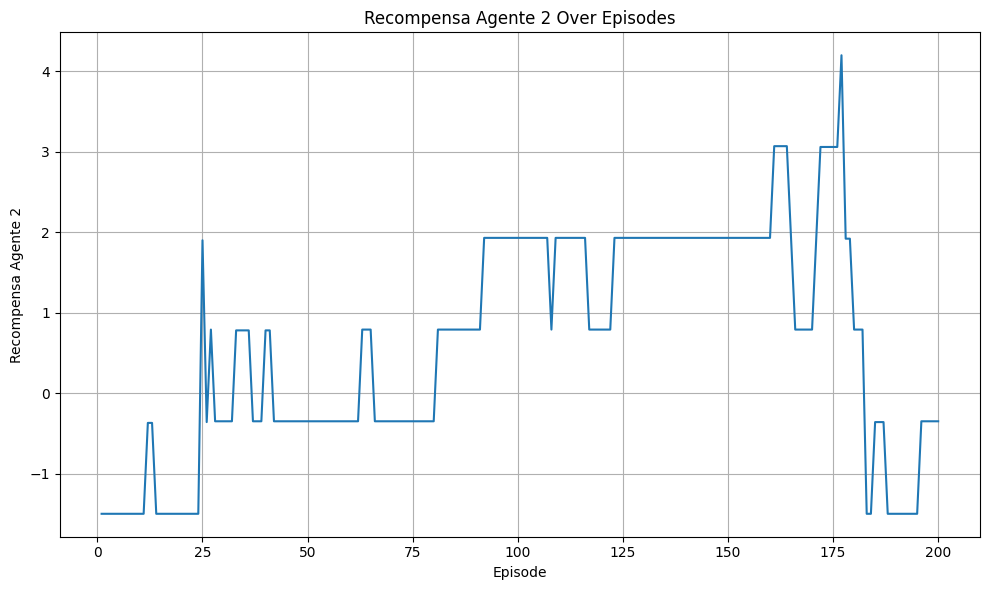

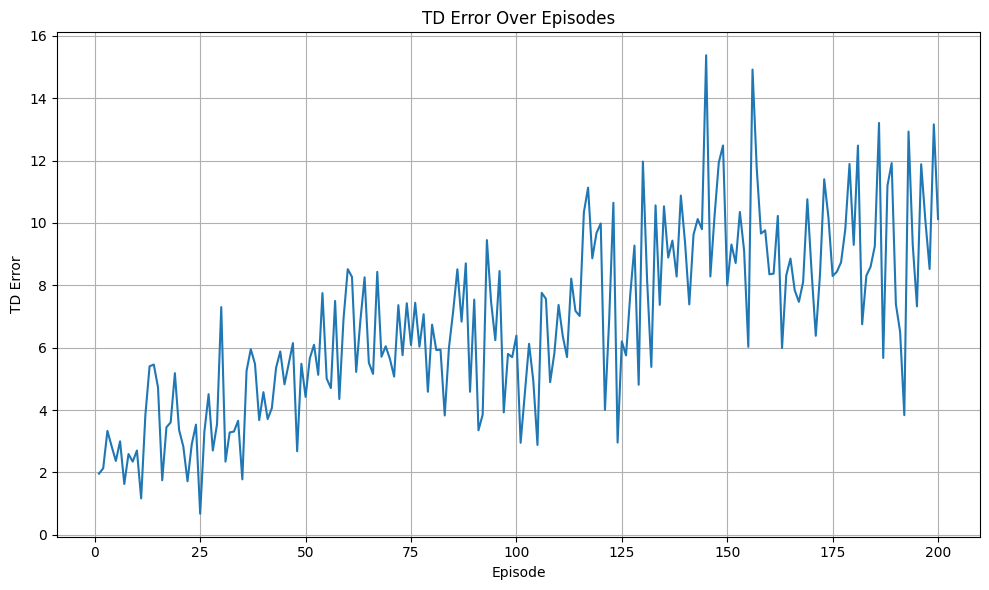

'\nbest_agent = []\nfor i in range(len(reward_per_agent_epoch[0])):\n    if reward_per_agent_epoch[1][i] > reward_per_agent_epoch[0][i]:\n        best_agent.append(1)\n    elif reward_per_agent_epoch[1][i] == reward_per_agent_epoch[0][i]:\n        best_agent.append(0)\n    else:\n        best_agent.append(-1)\n\ndraw_history(best_agent, "Performance of agent 2 over agent 1")\n'

In [101]:
draw_history(reward_per_epoch, "Recompensa colectiva")
draw_history(reward_per_agent_epoch[0], "Recompensa Agente 1")
draw_history(reward_per_agent_epoch[1], "Recompensa Agente 2")
draw_history(td_error_per_epoch, "TD Error")

'''
best_agent = []
for i in range(len(reward_per_agent_epoch[0])):
    if reward_per_agent_epoch[1][i] > reward_per_agent_epoch[0][i]:
        best_agent.append(1)
    elif reward_per_agent_epoch[1][i] == reward_per_agent_epoch[0][i]:
        best_agent.append(0)
    else:
        best_agent.append(-1)

draw_history(best_agent, "Performance of agent 2 over agent 1")
'''

Animación aleatoria:

In [ ]:
animations = list(filter(lambda f: f.endswith(".svg"), os.listdir(exp_config["renders"])))
random_animation = random.choice(animations)
print(random_animation)
display(SVG(os.path.join(exp_config["renders"], random_animation)))